In [1]:
# importing libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score

In [2]:
# loading dataset
df = pd.read_csv("df_salary.csv")

In [3]:
# binning the target variable - salary
bins = [-1, 30000, 60000, 90000, 150000, float('inf')]
labels = ['0-30k', '30k-60k', '60k-90k', '90k-150k', 'Unclassified']

df['Salary_Group'] = pd.cut(df['SALARY'], bins=bins, labels=labels)

print("\nTarget Class Distribution (New Bins):")
print(df['Salary_Group'].value_counts())


Target Class Distribution (New Bins):
Salary_Group
30k-60k         167156
60k-90k         115678
90k-150k         98431
Unclassified     89670
0-30k            75778
Name: count, dtype: int64


In [4]:
target_col = 'Salary_Group'

# Drop raw salary + target
X = df.drop(['SALARY', 'Salary_Group'], axis=1)
y = df[target_col]

# Encode target bins (0–30k, 30–60k, 60–90k, 90–150k, Unclassified)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# One-hot encode all categorical columns
X = pd.get_dummies(X, drop_first=True)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
# splitting the data into train and test (80-20)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

In [6]:
# gradient boosting model

gb_clf = GradientBoostingClassifier(
    n_estimators=300,        # Stronger model than default 100
    learning_rate=0.05,     # Lower LR + more estimators = better generalization
    max_depth=3,
    subsample=0.8,
    random_state=42
)

# Train
gb_clf.fit(X_train, y_train)

# Predict
y_pred = gb_clf.predict(X_test)

In [7]:
# metrics

print(f"Test Set Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")

print("Classification Report:")
print(classification_report(
    y_test, y_pred,
    target_names=le.classes_
))

Test Set Accuracy: 0.7036

Classification Report:
              precision    recall  f1-score   support

       0-30k       0.74      0.65      0.69     15156
     30k-60k       0.65      0.75      0.69     33431
     60k-90k       0.59      0.46      0.52     23136
    90k-150k       0.63      0.69      0.66     19686
Unclassified       1.00      1.00      1.00     17934

    accuracy                           0.70    109343
   macro avg       0.72      0.71      0.71    109343
weighted avg       0.70      0.70      0.70    109343



  0%|          | 0/50 [00:00<?, ?it/s]

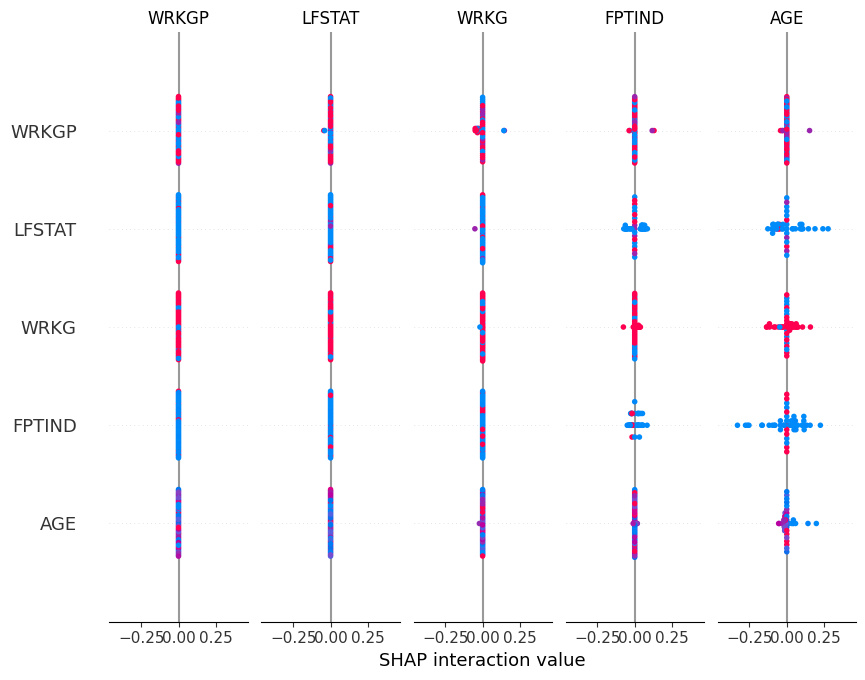

In [11]:
# visualization

import shap
import numpy as np

# take small subset for speed
X_sample = X_train[:50]

explainer = shap.KernelExplainer(gb_clf.predict_proba, X_sample)
shap_values = explainer.shap_values(X_sample)

shap.summary_plot(shap_values, X_sample, feature_names=X.columns)
